# Load in some packages


*   [ta](https://github.com/bukosabino/ta)
* [xgboost](https://xgboost.readthedocs.io/en/latest/index.html)

In [1]:
%%sh
pip install ta
pip install pandas_market_calendars
pip install xgboost
pip install pandas
pip install sklearn
pip install matplotlib
pip install eli5
pip install seaborn
pip install pandas_datareader

  Created wheel for ta: filename=ta-0.4.7-cp36-none-any.whl size=18553 sha256=c9df9e57ad4b3b516991c148c41189dcef3a6f085ddb98c5d040a63604917256
  Stored in directory: /home/spencer/.cache/pip/wheels/fe/58/16/b989347aa65ea8047524fdf38b5e70e2605e58eb8e46396368
Successfully built ta
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=ecaf44fefeb555a81cd5c205f66b5749771618d7a3abc3dd89238385b87c088e
  Stored in directory: /home/spencer/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
  Created wheel for tabulate: filename=tabulate-0.8.5-cp36-none-any.whl size=23255 sha256=000277adc78da38d41f4c858052202823588b0e56f06346fc0607f8118633b71
  Stored in directory: /home/spencer/.cache/pip/wheels/e1/41/5e/e201f95d90fc84f93aa629b6638adacda680fe63aac47174ab
Successfully built tabulate


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
from sklearn.model_selection import train_test_split
from ta import *
from scipy.stats import ttest_ind
from scipy import stats
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from scipy import stats
import pandas_datareader.data as web
from datetime import datetime
from sklearn.feature_selection import SelectFromModel
from dateutil.rrule import *
import pandas_market_calendars as mcal
import time
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost import XGBClassifier
from eli5.sklearn import PermutationImportance
import sklearn
import eli5
from sklearn.neighbors import KNeighborsClassifier

# Change some pandas defaults

In [3]:
def start():
    options = {
        'display': {
            'max_columns': None,
            'max_colwidth': 25,
            'expand_frame_repr': False,  # Don't wrap to multiple pages
            'max_rows': 100,
            'max_seq_items': 50,         # Max length of printed sequence
            'precision': 4,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   # Controls SettingWithCopyWarning
        }
    }
    for category, option in options.items():
        for op, value in option.items():
            pd.set_option(f'{category}.{op}', value)  # Python 3.6+
start()

# Load in historical data for the SPY ETF

In [82]:
spy = web.DataReader("SPY", 'yahoo', '1993-01-01').reset_index()
spy.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,1993-01-29,43.9688,43.7500,43.9688,43.9375,1003200.0,26.5840
1,1993-02-01,44.2500,43.9688,43.9688,44.2500,480500.0,26.7730
2,1993-02-02,44.3750,44.1250,44.2188,44.3438,201300.0,26.8298
3,1993-02-03,44.8438,44.3750,44.4062,44.8125,529400.0,27.1134
4,1993-02-04,45.0938,44.4688,44.9688,45.0000,531500.0,27.2268


In [441]:
spy.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
2465,2019-10-18,299.400,297.030,298.69,297.970,6.4304e+07,297.970
2466,2019-10-21,300.210,298.940,299.42,299.990,3.9049e+07,299.990
2467,2019-10-22,300.900,298.910,300.58,299.010,4.8595e+07,299.010
2468,2019-10-23,299.940,298.500,298.73,299.880,3.4352e+07,299.880
2469,2019-10-24,301.065,299.465,300.91,300.235,2.5522e+07,300.235


In [91]:
spy.shape

(6734, 7)

# get target

In [57]:
def get_target(df, days_out):
    # avoid a copy warning from pandas
    df = spy.copy()
    # get the close price X days out
    df['x_close'] = df['Close'].shift(days_out)
    # round the close price down
    df['Up Price'] = df['Close'].apply(np.ceil)
    # is close price rounded up greater than 
    # the close price x days out 
    df['Up'] = df['x_close'] > df['Up Price']

    # return the target
    return df['Up']

In [90]:
days_out = -20
target = get_target(spy)
print(target.shape)
target.tail(30)

(6734,)


6704    False
6705    False
6706    False
6707    False
6708    False
6709    False
6710     True
6711     True
6712     True
6713     True
6714    False
6715    False
6716    False
6717    False
6718    False
6719    False
6720    False
6721    False
6722    False
6723    False
6724    False
6725    False
6726    False
6727    False
6728    False
6729    False
6730    False
6731    False
6732    False
6733    False
Name: Up, dtype: bool

In [59]:
target.value_counts(normalize=True)

True     0.5731
False    0.4269
Name: Up, dtype: float64

# Wrangle

In [78]:
def wrangle(df, drop_date=True):
    df = df.copy()

    # change Date to datetime type
    df['Date'] = pd.to_datetime(df['Date'])
    # change date to index
    df.index = pd.DatetimeIndex(df['Date'])

    # not sure if this is needed, but since i'm doing just a basic train test
    # split i want to make sure it's sorted
    df = df.sort_index()

    # add some time features
    df['Day of Week'] = df['Date'].dt.weekday
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    df['Week'] = df['Date'].dt.quarter

    # drop the actual date column
    if drop_date:
        df = df.drop('Date', axis=1)
        
    # Daily High - Daily Low
    df['High - Low'] = df['High'] - df['Low']
    df['High - Low as % of Close'] = df['High - Low'] / df['Close']
    # High - Close
    df['High - Close'] = df['High'] - df['Close']
    df['High - Close as % of Close'] = df['High - Close'] / df['Close']
    # High - Open
    df['High - Open'] = df['High'] - df['Open']
    df['High - Open as % of Close'] = df['High - Open'] / df['Close']
    # Today Open - Yesterday Close
    df['Open - Close'] = df['Open'] - df['Close'].shift(1)
    df['Open - Close as % of Close'] = df['Open - Close'] / df['Close']


    # add all the technical analysis features from ta
    df = add_all_ta_features(df, "Open", "High", "Low", "Close",
                               "Volume", fillna=False)

    # some of the features use ~45 day rolling averages and stuff
    # so i'll just skip the first 45 days
    # and then i'll also remove the days that wont have the target
    # since it hasn't happened yet (20 days out)
    df = df.iloc[45:]

    # i'm just going to divide every feature by every other feature
    # there's gotta be a pattern in the data somewhere right
    div_features = pd.DataFrame()
    cols = df.select_dtypes('number').columns.tolist()
    for first_col in cols:
        for second_col in cols:
            div_features['{} / {}'.format(first_col, second_col)] = df[first_col] / df[second_col]

    df = pd.concat([df, div_features], axis=1)
    
    # now i gotta do something about all the inf values i just created
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.interpolate(method='time')
    df = df.fillna(df.mean())

    # delete all columns that are only one value
    nunique = df.nunique()
    df = df.drop(nunique[nunique == 1].index.tolist(), axis=1)
    
    # delete the columns that are over 50% missing
    perc_missing = df.isna().sum() / len(df)
    df = df.drop(perc_missing[perc_missing > .50].index.tolist(), axis=1)
    
    # done
    return df 

In [95]:
# wrangle only the data for which i'd have the target
df = wrangle(spy.iloc[:days_out])
df.shape

(6669, 5766)

In [97]:
y = target[45:days_out]

# EDA

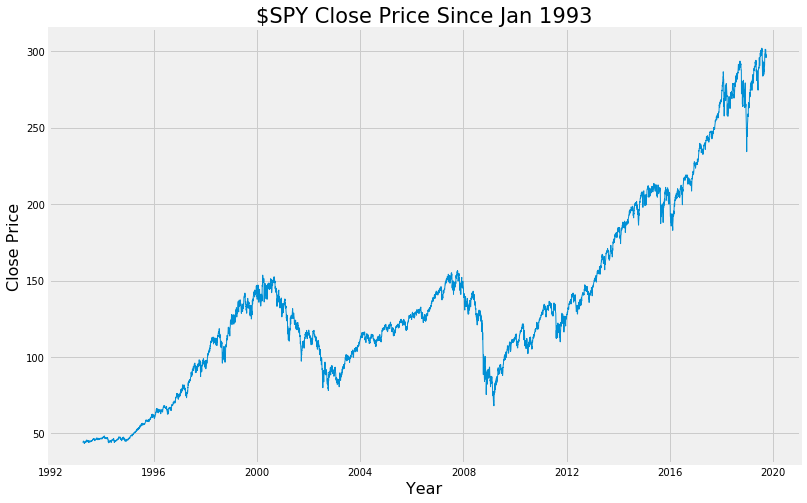

In [14]:
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')
plt.plot(df.index, df['Close'], linewidth=1)
plt.title('$SPY Close Price Since Jan 1993', fontsize=21)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Close Price', fontsize=16)
plt.show()

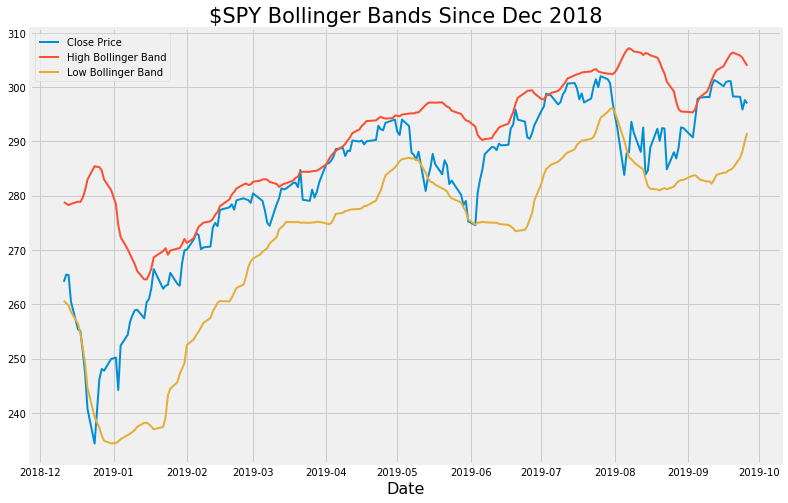

In [39]:
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')
close = plt.plot(df.iloc[-200:].index, df['Close'].iloc[-200:], linewidth=2, label='Close Price')
bbh = plt.plot(df.iloc[-200:].index, df['volatility_bbh'].iloc[-200:], linewidth=2, label='High Bollinger Band')
bbl = plt.plot(df.iloc[-200:].index, df['volatility_bbl'].iloc[-200:], linewidth=2, label='Low Bollinger Band')
plt.title('$SPY Bollinger Bands Since Dec 2018', fontsize=21)
plt.xlabel('Date', fontsize=16)
plt.legend()
plt.show()

# Fit the model

In [98]:
X_train = df.iloc[:-150 + days_out]
X_test = df.iloc[-150:]
y_train = y[:-150 + days_out]
y_test = y[-150:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6499, 5766), (6499,), (150, 5766), (150,))

In [102]:
X_train.index.max()

Timestamp('2019-01-24 00:00:00')

In [103]:
X_test.index.min()

Timestamp('2019-02-25 00:00:00')

In [99]:
%%time

clf = ExtraTreesClassifier(n_jobs = -1,
                           n_estimators = 100,
                           random_state = 42)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
# 0.6

0.6933333333333334
CPU times: user 10.7 s, sys: 388 ms, total: 11.1 s
Wall time: 4.55 s


In [101]:
y_test.value_counts(normalize=True)

True     0.6
False    0.4
Name: Up, dtype: float64

In [332]:
np.unique(ypred, return_counts=True)

(array([False,  True]), array([ 55, 259]))

# Tuning

In [333]:
n_estimators = [100,200,300,400,500,600,800,1200]
max_depth = [5,6,7,8,9,10,11,12,13,14,15,20,25,30,35,40,45,50]
min_samples_split = [2,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,25,30,35,40,45,50,55,60,70,80,90,100]
min_samples_leaf = [1, 2, 5, 10,15,20,25] 

clf = ExtraTreesClassifier(n_jobs = -1,random_state = 42)

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = RandomizedSearchCV(clf, hyperF,n_iter=100, cv = 5, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.5min finished


In [334]:
bestF.best_params_

{'n_estimators': 500,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_depth': 5}

In [106]:
clf = ExtraTreesClassifier(n_jobs = -1,
                           n_estimators = 100,
                           random_state = 42)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
#0.6369426751592356


0.6133333333333333


In [336]:
y_test.iloc[-days_out:].value_counts(normalize=True)

True     0.6433
False    0.3567
Name: Up, dtype: float64

In [205]:
np.unique(ypred, return_counts=True)

(array([False,  True]), array([27, 74]))